In [164]:
import networkx as nx
import numpy as np
import pandas as pd
import subprocess

# %matplotlib notebook
%matplotlib inline

In [212]:
def barabasi_albert(n=10, m=4):
    G = nx.barabasi_albert_graph(n, m)
    G.graph["dissemination"] = "flooding"
    solving_rate = np.random.exponential(n, n).astype("d")
    for i in range(n):
        G.nodes[i]["compute"] = solving_rate[i] / np.sum(solving_rate)
    n_edges = len(G.edges)
    distance = np.random.uniform(low=1, high=3, size=n_edges)
    for (a, b) in G.edges:
        G.edges[a, b]["distance"] = distance[i]
        G.edges[a, b]["delay"] = f"uniform {distance[i] * 0.5} {distance[i] * 1.5}"
        G.edges[a, b]["spring_weight"] = 1 / distance[i]
    distances = nx.shortest_paths()
    return G


def sim(G, protocol="nakamoto", activation_delay=1, activations=1000):
    G = G.copy()
    G.graph["activation_delay"] = activation_delay
    G.graph["activations"] = activations
    G.graph["protocol"] = protocol
    with subprocess.Popen(
        ["dune", "exec", "../../ocaml/bin/igraph_runner.exe"],
        stdin=subprocess.PIPE,
        stdout=subprocess.PIPE,
        text=True,
    ) as process:
        for line in nx.generate_graphml(G):
            try:
                process.stdin.write(line)
            except BrokenPipeError as e:
                pass
        out, err = process.communicate()
        return nx.parse_graphml(out)


def draw(G, size="compute", layout=None):
    G = G.copy()
    size = nx.get_node_attributes(G, size).values()
    size = np.array(list(size)) * 1000
    size = np.interp(size, (size.min(), size.max()), (100, 2000))
    return_layout = False
    if not layout:
        layout = nx.spring_layout(G, weight="spring_weight")
        return_layout = True
    nx.draw(G, pos=layout, node_size=size)
    if return_layout:
        return layout


def print_(G):
    for l in nx.generate_graphml(G):
        print(l)

In [222]:
dict(nx.all_pairs_dijkstra_path_length(G, weight="distance"))

{'n0': {'n0': 0,
  'n6': 1.98760852045,
  'n5': 1.98760852045,
  'n4': 1.98760852045,
  'n3': 1.98760852045,
  'n2': 1.98760852045,
  'n1': 1.98760852045},
 'n1': {'n1': 0,
  'n6': 1.98760852045,
  'n5': 1.98760852045,
  'n0': 1.98760852045,
  'n3': 3.9752170409,
  'n2': 3.9752170409,
  'n4': 3.9752170409},
 'n2': {'n2': 0,
  'n5': 1.98760852045,
  'n0': 1.98760852045,
  'n6': 3.9752170409,
  'n3': 3.9752170409,
  'n1': 3.9752170409,
  'n4': 3.9752170409},
 'n3': {'n3': 0,
  'n6': 1.98760852045,
  'n5': 1.98760852045,
  'n0': 1.98760852045,
  'n1': 3.9752170409,
  'n2': 3.9752170409,
  'n4': 3.9752170409},
 'n4': {'n4': 0,
  'n0': 1.98760852045,
  'n6': 3.9752170409,
  'n5': 3.9752170409,
  'n3': 3.9752170409,
  'n2': 3.9752170409,
  'n1': 3.9752170409},
 'n5': {'n5': 0,
  'n6': 1.98760852045,
  'n3': 1.98760852045,
  'n2': 1.98760852045,
  'n1': 1.98760852045,
  'n0': 1.98760852045,
  'n4': 3.9752170409},
 'n6': {'n6': 0,
  'n5': 1.98760852045,
  'n3': 1.98760852045,
  'n1': 1.9876085

Entering directory '/home/patrik/devel/cpr'
Entering directory '/home/patrik/devel/cpr'


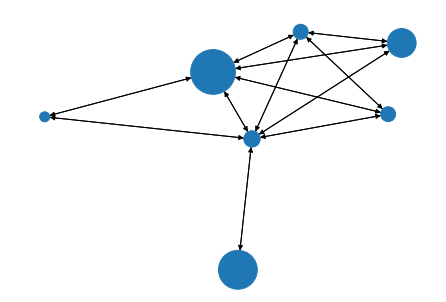

In [213]:
G = sim(barabasi_albert(n=7), activation_delay=1, activations=1000)
layout = draw(G)

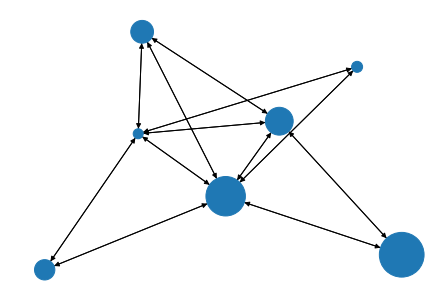

In [206]:
draw(G, size="activations", layout=layout)

In [214]:
nodes = pd.DataFrame([v for (_, v) in G.nodes.data()])
for k in ["protocol"]:
    nodes[k] = [G.graph[k] for _ in range(len(G.nodes))]
nodes["relative_reward"] = nodes.reward / np.sum(nodes.reward)
nodes["relative_activations"] = nodes.reward / np.sum(nodes.activations)
nodes["efficiency"] = nodes.reward / G.graph["head_progress"] / nodes.compute
nodes["efficiency"] = nodes.efficiency.fillna(0)
nodes

,activations,reward,compute,protocol,relative_reward,relative_activations,efficiency
0,86.0,34.0,0.081933,nakamoto,0.075388,0.034,0.920122
1,72.0,21.0,0.076066,nakamoto,0.046563,0.021,0.612138
2,55.0,2.0,0.060263,nakamoto,0.004435,0.002,0.073587
3,170.0,76.0,0.155080,nakamoto,0.168514,0.076,1.086632
4,232.0,71.0,0.243009,nakamoto,0.157428,0.071,0.647827
5,317.0,231.0,0.307156,nakamoto,0.512195,0.231,1.667539
6,68.0,16.0,0.076493,nakamoto,0.035477,0.016,0.463793
